# MNIST Image classification using CNN in TensorFlow

## 1. Import Modules

In [1]:
# Import TensorFlow
import tensorflow as tf
# Import MNIST dataset
from tensorflow.examples.tutorials import mnist
# Import numpy
import numpy as np
# Import matplotlib
import matplotlib.pyplot as plt

## 2. Read in MNIST data

In [2]:
# Read data
data = mnist.input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
# Shapes of training set
print("Training set (images) shape: {shape}".format(shape=data.train.images.shape))
print("Training set (labels) shape: {shape}".format(shape=data.train.labels.shape))

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=data.test.images.shape))
print("Test set (labels) shape: {shape}".format(shape=data.test.labels.shape))

image_hgt = 28
image_wid = 28
n_classes = 10

Training set (images) shape: (55000, 784)
Training set (labels) shape: (55000, 10)
Test set (images) shape: (10000, 784)
Test set (labels) shape: (10000, 10)


In [4]:
# Create dictionary of target classes
label_dict = {
    0: 'Zero',
    1: 'One',
    2: 'Two',
    3: 'Three',
    4: 'Four',
    5: 'Five',
    6: 'Six',
    7: 'Seven',
    8: 'Eight',
    9: 'Nine'
}

Text(0.5, 1.0, '(Label: Two)')

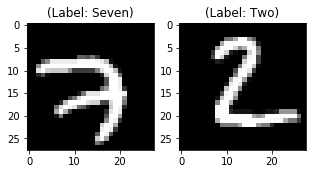

In [5]:
plt.figure(figsize=[5,5])

# Display first image in training data
plt.subplot(121)
img = np.reshape(data.train.images[0], (image_hgt,image_wid))
lbl = np.argmax(data.train.labels[0,:])
plt.imshow(img, cmap='gray')
plt.title("(Label: " + str(label_dict[lbl]) + ")")

# Display second image in testing data
plt.subplot(122)
img = np.reshape(data.test.images[1], (image_hgt,image_wid))
lbl = np.argmax(data.test.labels[1,:])
plt.imshow(img, cmap='gray')
plt.title("(Label: " + str(label_dict[lbl]) + ")")

## 3. Data preprocessing

In [6]:
# Reshape training and testing images
train_X = data.train.images.reshape(-1, image_hgt, image_wid, 1) # number of samples, length, width, number of channels
test_X = data.test.images.reshape(-1, image_hgt, image_wid, 1) # number of samples, length, width, number of channels
print(train_X.shape, test_X.shape)

train_Y = data.train.labels
test_Y = data.test.labels
print(train_Y.shape, test_Y.shape)

(55000, 28, 28, 1) (10000, 28, 28, 1)
(55000, 10) (10000, 10)


## 4. Training Parameters

In [7]:
learning_rate = 0.01
epochs = 50
batch_size = 64

## 5. Model

### 5.1. Helper Functions

In [8]:
# Weights dictionary        
weight_dict = {
    'filterWC1' : tf.get_variable('FWC1', shape=(3,3,1,32), initializer=tf.contrib.layers.xavier_initializer()),
    'filterWC2' : tf.get_variable('FWC2', shape=(3,3,32,64), initializer=tf.contrib.layers.xavier_initializer()),
    'fullyConnW' : tf.get_variable('FCW', shape=(7*7*64,64), initializer=tf.contrib.layers.xavier_initializer()),
    'OutputW' : tf.get_variable('OW', shape=(64,n_classes), initializer=tf.contrib.layers.xavier_initializer())
}

bias_dict = {
    'filterBC1' : tf.get_variable('FBC1', shape=(32), initializer=tf.contrib.layers.xavier_initializer()),
    'filterBC2' : tf.get_variable('FBC2', shape=(64), initializer=tf.contrib.layers.xavier_initializer()),
    'fullyConnB' : tf.get_variable('FCB', shape=(64), initializer=tf.contrib.layers.xavier_initializer()),
    'OutputB' : tf.get_variable('OB', shape=(n_classes), initializer=tf.contrib.layers.xavier_initializer())
}

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
# Helper functions
def conv2d(inp, filter_weight, filter_bias, strides=1):
    inp = tf.nn.conv2d(inp, filter_weight, strides = [1, strides, strides, 1], padding = 'SAME')
    inp = tf.nn.bias_add(inp, filter_bias)
    return tf.nn.relu(inp)

def maxpool2d(inp, ksize=2):
    return tf.nn.max_pool(inp, ksize = [1, ksize, ksize, 1], strides = [1, ksize, ksize, 1], padding = 'SAME')
    
def flatten(inp, size):
    return tf.reshape(inp, [-1, size])
    
def fc(inp, fc_weight, fc_bias):
    fc = tf.matmul(inp, fc_weight)
    fc = tf.add(fc, fc_bias)
    return tf.nn.relu(fc)
    
def out(inp, out_weight, out_bias):
    out = tf.matmul(inp, out_weight)
    return tf.add(out, out_bias)

### 5.2. Network

In [10]:
def conv_net(inp, weight_dict, bias_dict):
    # Convolution Layer 1
    conv1 = conv2d(inp, weight_dict['filterWC1'], bias_dict['filterBC1'])
    conv1 = maxpool2d(conv1, ksize=2)
    
    # Convolution Layer 2
    conv2 = conv2d(conv1, weight_dict['filterWC2'], bias_dict['filterBC2'])
    conv2 = maxpool2d(conv2, ksize=2)
    
    # Flatten the convolution layer output
    flatten_layer = flatten(conv2, weight_dict['fullyConnW'].get_shape().as_list()[0])
    
    # Fully Connected Layer
    fc1 = fc(flatten_layer, weight_dict['fullyConnW'], bias_dict['fullyConnB'])
    
    # Output, class prediction
    out_layer = out(fc1, weight_dict['OutputW'], bias_dict['OutputB'])
    
    return out_layer
    

### 5.3. Loss and Optimizer

In [11]:
# Define placeholders
x = tf.placeholder(tf.float32, [None, image_hgt, image_wid, 1])
y = tf.placeholder(tf.float32, [None, n_classes])

In [12]:
# Prediction
pred = conv_net(x, weight_dict, bias_dict)

# Define the Cost function
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))

# Define the optimizer
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



### 5.4. Model Evaluation

In [13]:
# Here you check whether the index of the maximum value of the predicted image 
# is equal to the actual labelled image and both will be a column vector
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))

# Calculate accuracy across all the given images and average them out. 
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## 6. TensorFlow session

In [ ]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    # Variable must be initialized before a graph is used for the first time.
    sess.run(init)
    train_loss_list = []
    test_loss_list = []
    train_accuracy_list = []
    test_accuracy_list = []
    summary_writer = tf.summary.FileWriter('./Output', sess.graph)
    
    for epoch in range(epochs):
        for batch in range(len(train_X//batch_size)):
            batch_x = train_X[batch*batch_size:min(((batch+1)*batch_size), len(train_X))]
            batch_y = train_Y[batch*batch_size:min(((batch+1)*batch_size), len(train_Y))]
            
            opt = sess.run(optimizer, feed_dict = {x:batch_x, y:batch_y})
            train_loss, train_acc = sess.run([cost, accuracy], feed_dict = {x:batch_x, y:batch_y})
            
        print("Epoch " + str(epoch) + ", Loss = {:.6f}".format(train_loss) + ", Training Accuracy = {:.5f}".format(train_acc))
        
        
        # Calclate accuracy for all test images
        test_loss, test_acc = sess.run([cost, accuracy], feed_dict = {x:test_X, y:test_Y})
        print("Testing Accuracy: {:.5f}".format(test_acc))
        
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
        train_accuracy_list.append(train_acc)
        test_accuracy_list.append(test_acc)
        
    summary_writer.close()        

Epoch 0, Loss = nan, Training Accuracy = nan
Testing Accuracy: 0.87400


## 7. Visualize Loss

In [ ]:
plt.plot(range(epochs), train_loss, 'b', label='Training Loss')
plt.plot(range(epochs), test_loss, 'r', label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
plt.figure()
plt.show()

plt.plot(range(epochs), train_accuracy, 'b', label='Training Accuracy')
plt.plot(range(epochs), test_accuracy, 'r', label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
plt.figure()
plt.show()